In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install underthesea
!pip install pyvi
!pip install transformers
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.1 MB/s eta 0:00:00


In [3]:
import shutil
import os
import pandas as pd
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import sys
import logging
import re

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier

from underthesea import word_tokenize, text_normalize
from pyvi import ViTokenizer
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging


In [4]:
class DatasetConfig:
  train_csv_path:str = "/content/drive/MyDrive/train_nor_811.xlsx"
  test_csv_path:str = "/content/drive/MyDrive/test_nor_811.xlsx"

In [5]:
class DataProcess:
  @staticmethod
  def load_df(csv_path):
    """
    load and return dataframe of dataset
    """
    df = pd.read_excel(csv_path)
    df.columns = ['index', 'Emotion', 'Sentence']
    df.drop(columns=['index'], axis=1)
    return df


train_df = DataProcess.load_df(DatasetConfig.train_csv_path)
test_df = DataProcess.load_df(DatasetConfig.test_csv_path)

train_df.head()

,index,Emotion,Sentence
0,188,Other,cho mình xin bài nhạc tên là gì với ạ
1,166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
3,316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
4,1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


# EDA the training dataset

In [6]:
train_df[['Sentence','Emotion']]

,Sentence,Emotion
0,cho mình xin bài nhạc tên là gì với ạ,Other
1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,Disgust
2,lo học đi . yêu đương lol gì hay lại thích học...,Disgust
3,uớc gì sau này về già vẫn có thể như cụ này :)),Enjoyment
4,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment
...,...,...
5543,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...,Disgust
5544,nhìn mặt héo queo luôn,Other
5545,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...,Other
5546,thích thân hình boss rồi nhan 😌,Enjoyment


In [7]:
# validate dataset => No blank datapoint
train_df.info()
print("=====================================")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5548 entries, 0 to 5547
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     5548 non-null   int64 
 1   Emotion   5548 non-null   object
 2   Sentence  5548 non-null   object
dtypes: int64(1), object(2)
memory usage: 130.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5548 entries, 0 to 5547
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     5548 non-null   int64 
 1   Emotion   5548 non-null   object
 2   Sentence  5548 non-null   object
dtypes: int64(1), object(2)
memory usage: 130.2+ KB


In [8]:
# All existed labels
labels = train_df.Emotion.unique()
labels

array(['Other', 'Disgust', 'Enjoyment', 'Anger', 'Surprise', 'Sadness',
       'Fear'], dtype=object)

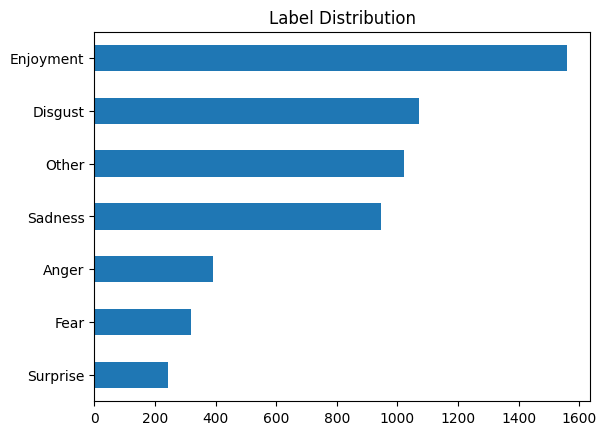

In [9]:
# Label distribution => Imblance dataset
train_df.Emotion.value_counts(ascending=True).plot.barh()
plt.title('Label Distribution')
plt.show()

In [10]:
# based on this histogram, choose sentence length fixed to 50 is good
train_df['length_of_text'] = [len(i.split(" ")) for i in train_df['Sentence']]
fig = px.histogram(train_df['length_of_text'], marginal='box', labels={'value': "Length of the Text"}, color=train_df['Emotion'] )
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)))
fig.update_layout(title_text = 'Distribution of the Length of Text by Emotion ', title_x=0.5, title_font=dict(size=20)  )
fig.show()

In [ ]:
FreqOfWords = train_df['Sentence'].str.split(expand=True)

In [ ]:
FreqOfWords = train_df['Sentence'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]
FreqOfWords_top200

.        1557
,        1196
không    1130
tao      1052
là       1006
         ... 
hiểu       81
:)         81
tưởng      81
lấy        80
😂          79
Length: 200, dtype: int64

In [ ]:
# "." is the most frequency word
fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0)
fig.update_layout(title_text = 'Words frequency in train dataset', title_x = 0.5, title_font=dict(size=20))
fig.update_traces(textinfo='label+value')
fig.show()

# Training & evaluation


## Decision Tree

In [ ]:
train_df['Cleaned_sen'] = train_df['Sentence'].apply(simple_preprocess)
train_df.head()

,index,Emotion,Sentence,length_of_text,Cleaned_sen
0,188,Other,cho mình xin bài nhạc tên là gì với ạ,10,cho mình xin bài nhạc tên là gì với ạ
1,166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,16,cho đáng đời con quỷ về nhà lôi con nhà mày ra...
2,1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...,14,lo học đi yêu đương lol gì hay lại thích học s...
3,316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :)),13,ước gì sau này về già vẫn có thể như cụ này
4,1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...,18,mỗi lần có video của con là cứ coi đi coi lại ...


In [20]:
LABEL2INDEX = {'Anger':      0,
                'Disgust':    1,
                'Enjoyment':  2,
                'Fear':       3,
                'Other':      4,
                'Sadness':    5,
                'Surprise':   6}
INDEX2LABEL = {0: 'Anger',
                1:'Disgust',
                2:'Enjoyment',
                3:'Fear',
                4:'Other',
                5:'Sadness',
                6:'Surprise'}

In [ ]:
# preprocessing training data
train_df['Clean_sentence'] = train_df['Sentence'].apply(lambda x: ' '.join(simple_preprocess(x)))
train_df['Numeric_emotion'] = train_df['Emotion'].apply(lambda x: LABEL2INDEX[x])

train_df.head()

,index,Emotion,Sentence,length_of_text,Clean_sentence,Numeric_emotion
0,188,Other,cho mình xin bài nhạc tên là gì với ạ,10,cho mình xin bài nhạc tên là gì với,4
1,166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,16,cho đáng đời con quỷ về nhà lôi con nhà mày ra...,1
2,1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...,14,lo học đi yêu đương lol gì hay lại thích học s...,1
3,316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :)),13,uớc gì sau này về già vẫn có thể như cụ này,2
4,1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...,18,mỗi lần có video của con là cứ coi đi coi lại ...,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df['Clean_sentence'], train_df['Numeric_emotion'],test_size=0.2,random_state=13)
X_train, y_train

(3579    tao đang thă mă ta sao thă người da đen no que...
 2326                      cái dòng mà dễ dãi hứ tao khinh
 3304                                             rụng tim
 5126                 ông tổ của những cái sừng là đây sao
 2426                                          cưng quá hà
                               ...                        
 153     chắc phải năm chưa nấu kiểu này rồi trước nấu ...
 866                                     đáng yêu vại trời
 2790    móng tay dài như vậy thì làm gì để sống phục v...
 74      rồi khi mày có ít tiền mày mới phát hiện ra cò...
 338                                  anh chờ đáng yêu ghê
 Name: Clean_sentence, Length: 4438, dtype: object,
 3579    4
 2326    1
 3304    5
 5126    6
 2426    2
        ..
 153     2
 866     2
 2790    1
 74      5
 338     2
 Name: Numeric_emotion, Length: 4438, dtype: int64)

In [ ]:
feature = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1,1), use_idf=1,smooth_idf=1,sublinear_tf=1)

In [ ]:
feature.fit(X_train)
x_train = feature.transform(X_train)
x_test = feature.transform(X_test)
feature.transform(train_df['Clean_sentence'])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning:

Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.



<5548x949 sparse matrix of type '<class 'numpy.float64'>'
	with 63196 stored elements in Compressed Sparse Row format>

In [ ]:
param_grid = {'criterion': ['gini','entropy'],
             'min_samples_split':[50,70,100,150],
             'max_features': ['sqrt','log2']}


i=1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(x_train,y_train):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = x_train[train_index],x_train[test_index]
    ytr,yvl = y_train.iloc[train_index],y_train.iloc[test_index]

    model = RandomizedSearchCV(estimator=DecisionTreeClassifier(class_weight={0:1,1:5}),param_distributions=param_grid,verbose=1)


    model.fit(xtr, ytr)
    #print (model.best_params_)
    pred=model.predict(xvl)
    print('f1_logistic', f1_score(np.array(yvl).reshape(-1, 1), pred, average='micro'))
    i+=1

print("Execution time: " + str((time.time() - start_time)) + ' ms')
print ('best parameters',model.best_params_)


1 of kfold 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits
f1_logistic 0.3355855855855856

2 of kfold 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits
f1_logistic 0.32882882882882886

3 of kfold 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits
f1_logistic 0.3277027027027027

4 of kfold 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits
f1_logistic 0.3179255918827508

5 of kfold 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits
f1_logistic 0.32130777903043967
Execution time: 1954.4838180541992 ms
best parameters {'min_samples_split': 150, 'max_features': 'sqrt', 'criterion': 'gini'}


Confusion Matrix 
 [[  1  41  14   3   2   4   0]
 [  4 107  33   6  11   6   0]
 [  1  88 132   3  13  15   0]
 [  0  18   9  13   1   6   0]
 [  1  73  50   5  16  21   1]
 [  1  72  45   0  16  16   0]
 [  0  22  13   0   1   3   0]]


<Axes: >

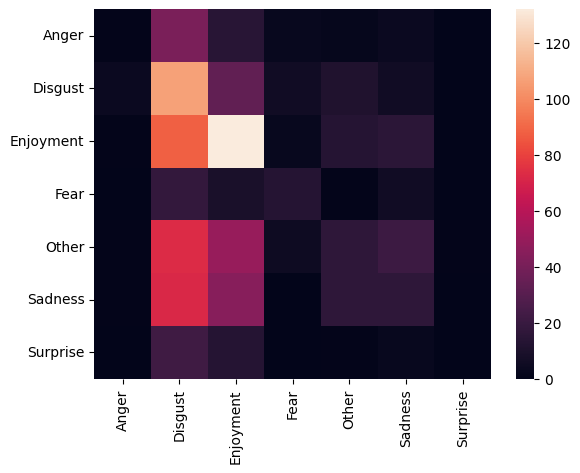

In [ ]:
print('Confusion Matrix \n')
class_names = test_dataset.label2index.keys()
sns.heatmap(confusion_matrix(yvl, pred), annot=False, xticklabels = class_names, yticklabels = class_names)

## Random forest

In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()
param_grid = {'criterion': ['entropy'],
             'min_samples_split':np.arange(10,100,20),
             'max_features': ['sqrt'],
             'n_estimators':[10,20,30]}

i=1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(x_train,y_train):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = x_train[train_index],x_train[test_index]
    ytr,yvl = y_train.iloc[train_index],y_train.iloc[test_index]

    model = RandomizedSearchCV(estimator=RandomForestClassifier(),param_distributions=param_grid,verbose=1)


    model.fit(xtr, ytr)
    #print (model.best_params_)
    pred= model.predict(xvl).reshape(-1, 1)
    print('f1_logistic', f1_score(np.array(yvl).reshape(-1, 1), pred, average='micro'))
    i+=1

print("Execution time: " + str((time.time() - start_time)) + ' ms')
print ('best parameters',model.best_params_)


1 of kfold 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits
f1_logistic 0.42117117117117114

2 of kfold 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits
f1_logistic 0.42680180180180183

3 of kfold 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits
f1_logistic 0.42792792792792794

4 of kfold 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits
f1_logistic 0.4024802705749718

5 of kfold 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits
f1_logistic 0.41262683201803835
Execution time: 89.29282665252686 ms
best parameters {'n_estimators': 30, 'min_samples_split': 50, 'max_features': 'sqrt', 'criterion': 'entropy'}


Confusion Matrix 
 [[  4  26  23   2   8   2   0]
 [  3  64  67   5  22   6   0]
 [  2  19 200   5  18   7   1]
 [  1   6  19  15   2   4   0]
 [  2  23  86   4  43   9   0]
 [  1  29  63   0  21  36   0]
 [  0   2  24   0   8   1   4]]


<Axes: >

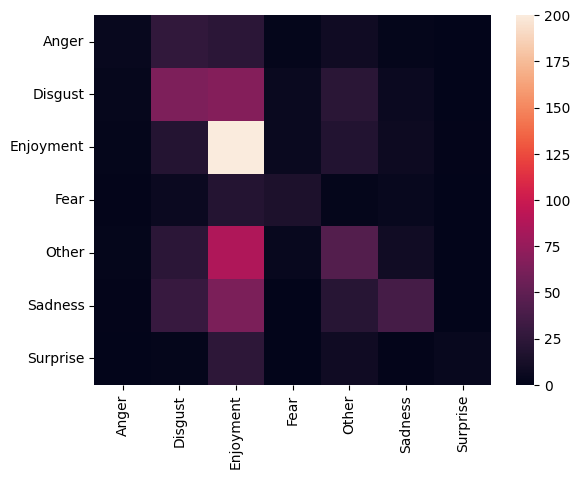

In [ ]:
print('Confusion Matrix \n',confusion_matrix(yvl, pred))
class_names = test_dataset.label2index.keys()
sns.heatmap(confusion_matrix(yvl, pred), annot=False, xticklabels = class_names, yticklabels = class_names)

## MLP as classifier + PhoBERT as feature extractor

In [11]:
# set random seed
def seed_everything(seed_value):
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(13)

In [12]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.label2index = {'Anger':      0,
                            'Disgust':    1,
                            'Enjoyment':  2,
                            'Fear':       3,
                            'Other':      4,
                            'Sadness':    5,
                            'Surprise':   6}
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)
        # Encode_plus will:
        # 1. split text into token
        # 2. Add the '[CLS]' and '[SEP]' token to the start and end
        # 3. Truncate/Pad sentence to max length
        # 4. Map token to their IDS
        # 5. Create attention mask
        # 6. Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

    def get_input_data(self, row):
      # Preprocessing: {remove icon, special character, lower}
      text = row['Sentence']
      text = ' '.join(simple_preprocess(text))
      label = self.label2index[row['Emotion']]

      return text, label

In [13]:
# config
class TrainingConfig:
  num_epoch = 10
  num_fold = 5
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

# model
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained("vinai/phobert-base")
    self.drop = nn.Dropout(p=0.3)
    self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
    nn.init.normal_(self.fc.weight, std=0.02)
    nn.init.normal_(self.fc.bias, 0)

  def forward(self, input_ids, attention_mask):
    last_hidden_state, output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict=False # Dropout will errors if without this
    )
    x = self.drop(output)
    x = self.fc(x)
    return x

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
# define training flow
class ModelTrainer:
  @staticmethod
  def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
      input_ids = data['input_ids'].to(TrainingConfig.device)
      attention_mask = data['attention_masks'].to(TrainingConfig.device)
      targets = data['targets'].to(TrainingConfig.device)

      optimizer.zero_grad()
      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )

      loss = criterion(outputs, targets)
      _, pred = torch.max(outputs, dim=1)

      correct += torch.sum(pred == targets)
      losses.append(loss.item())
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
      lr_scheduler.step()
    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

  @staticmethod
  def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(TrainingConfig.device)
            attention_mask = data['attention_masks'].to(TrainingConfig.device)
            targets = data['targets'].to(TrainingConfig.device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)


In [15]:
# split train df into n folds
def fold_loaders(df, fold):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(train_df, TrainingConfig.tokenizer, max_len=50)
    valid_dataset = SentimentDataset(valid_df, TrainingConfig.tokenizer, max_len=50)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

    return train_loader, valid_loader

test_dataset = SentimentDataset(test_df, TrainingConfig.tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

In [16]:
# init fold
skf = StratifiedKFold(n_splits=TrainingConfig.num_fold)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.Emotion)):
  train_df.loc[val_, "kfold"] = fold

In [ ]:
# training bert
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = fold_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=7).to(TrainingConfig.device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*TrainingConfig.num_epoch
            )
    best_acc = 0
    for epoch in range(TrainingConfig.num_epoch):
      print(f'Epoch {epoch+1}/{TrainingConfig.num_epoch}')
      print('-'*30)

      ModelTrainer.train(model, criterion, optimizer, train_loader)
      val_acc = ModelTrainer.eval()

      if val_acc > best_acc:
        best_acc = val_acc
        best_model = model.state_dict()
torch.save(best_model, f'/content/drive/MyDrive/fold_{fold+1}_epoch_{epoch+1}.pth')

-----------Fold: 1 ------------------
Epoch 1/10
------------------------------
Train Accuracy: 0.32086525461919785 Loss: 1.7727344104711957
Valid Accuracy: 0.48558558558558557 Loss: 1.4501597676958358
Epoch 2/10
------------------------------
Train Accuracy: 0.5150968904912123 Loss: 1.3621647797471328
Valid Accuracy: 0.5324324324324324 Loss: 1.335798226084028
Epoch 3/10
------------------------------
Train Accuracy: 0.6293375394321766 Loss: 1.0926403145995929
Valid Accuracy: 0.5675675675675675 Loss: 1.2119762548378537
Epoch 4/10
------------------------------
Train Accuracy: 0.7057232987832357 Loss: 0.9091074027174668
Valid Accuracy: 0.5972972972972973 Loss: 1.2159784721476692
Epoch 5/10
------------------------------
Train Accuracy: 0.742000901306895 Loss: 0.761490859466491
Valid Accuracy: 0.5963963963963964 Loss: 1.2184751468045372
Epoch 6/10
------------------------------
Train Accuracy: 0.7924740874267688 Loss: 0.6462062893689965
Valid Accuracy: 0.6009009009009009 Loss: 1.25271950

In [17]:
def test(data_loader):
  models = []
  # for fold in range(skf.n_splits):
  model = SentimentClassifier(n_classes=7)
  model.to(TrainingConfig.device)
  model.load_state_dict(torch.load('/content/drive/MyDrive/fold_5_epoch_10.pth'))
  model.eval()
  models.append(model)

  texts = []
  predicts = []
  predict_probs = []
  real_values = []
  for data in data_loader:
    text = data['text']
    input_ids = data['input_ids'].to(TrainingConfig.device)
    attention_mask = data['attention_masks'].to(TrainingConfig.device)
    targets = data['targets'].to(TrainingConfig.device)

    total_outs = []
    for model in models:
      with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        total_outs.append(outputs)

    total_outs = torch.stack(total_outs)
    _, pred = torch.max(total_outs.mean(0), dim=1)
    texts.extend(text)
    predicts.extend(pred)
    predict_probs.extend(total_outs.mean(0))
    real_values.extend(targets)

  predicts = torch.stack(predicts).cpu()
  predict_probs = torch.stack(predict_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  print(classification_report(real_values, predicts))
  return real_values, predicts


test_dataset = SentimentDataset(test_df, TrainingConfig.tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.54      0.35      0.42        40
           1       0.53      0.64      0.58       132
           2       0.66      0.61      0.63       193
           3       0.65      0.67      0.66        46
           4       0.50      0.48      0.49       129
           5       0.63      0.69      0.66       116
           6       0.59      0.51      0.55        37

    accuracy                           0.59       693
   macro avg       0.59      0.56      0.57       693
weighted avg       0.59      0.59      0.59       693



<Axes: >

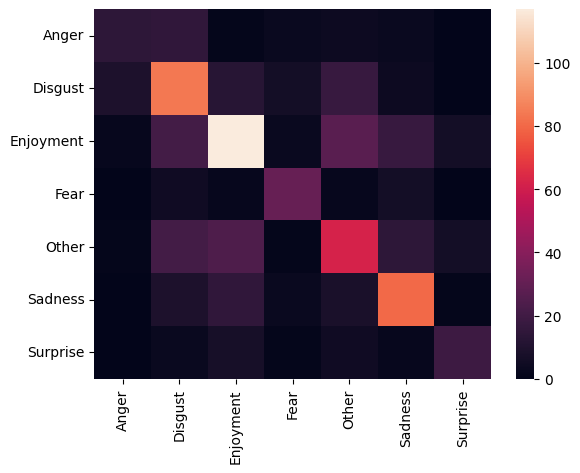

In [18]:
class_names = test_dataset.label2index.keys()
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

In [23]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(25):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].Sentence)
    print(f'Predicted: ({INDEX2LABEL[int(wrong_label[i])]}) --vs-- Real label: ({INDEX2LABEL[int(real_values[wrong_arr[i]])]})')

--------------------------------------------------
cho nghỉ viêc mói đúng sao goi là kỷ luật
Predicted: (Enjoyment) --vs-- Real label: (Other)
--------------------------------------------------
kinh vãi 😡
Predicted: (Other) --vs-- Real label: (Sadness)
--------------------------------------------------
bố không thích nộp đấy mày thích ý kiến không
Predicted: (Disgust) --vs-- Real label: (Anger)
--------------------------------------------------
một hành động đẹp đầy tính nhân văn ☺️☺️
Predicted: (Sadness) --vs-- Real label: (Fear)
--------------------------------------------------
per trình mày vẫn còn thấp chán =))
Predicted: (Sadness) --vs-- Real label: (Other)
--------------------------------------------------
có ai như tao vô đọc bình luận 🤣 tao cười tao xĩu
Predicted: (Disgust) --vs-- Real label: (Enjoyment)
--------------------------------------------------
sao lại cứ phải thế nhỉ
Predicted: (Other) --vs-- Real label: (Disgust)
--------------------------------------------------
p

# Summarize report + insight
## Data Insights
- ***LABEL DISTR:*** Based on the label distribution, the dataset is imbalance. The frequency of Enjoyment has high representation, otherwise the Anger, Fear and Suprise are under-representation.
- ***SENTENCE LENGTH DISTR:*** Almost sentence lengths are limited to ~50 token. The distributions of sentence lengths are quite balance among all labels (have short also with long sentences) except Suprise because of small amount of datapoint.
- ***TOKEN DISTRIBUTION:*** ".", "," are the most popular token, following by other Vietnamese stopwords, which wisely used by people in the internet.
- Sentences contain many of emoji (icon) which I don't want to remove because of their meaning (e.g. smile emoiji usually means enjoyment, angry emoji means the anger, ...)
- Containing specific unofficial cases in Vietnamese and slang words which difficult to capture the true meaning. (e.g. hom nay cac' ban. nhu the nao`, ...)


## Feature insights
*Notes: Because of the time limit, I didn't have a chance to try to produce the experiments between TF-IDF with PhoBERT on the same classifier (for fair comparision) also other methods to boost the performance of the model on this dataset, but I'll provide some of ideas that I might try.*

- TF-IDF did the work, but not good enough for this dataset. It simply could capture the appearancies of word in the sentence with its label (e.g. Enjoy words will be within in Enjoy sentences). It's just not enough for the classifier when this dataset is natural and human, it's needed more complex features and context to well represent for this dataset.

- PhoBERT is better! Accordingly to this repo, it has been trained on a large amnounts of Vietnamese text data, and proven the improvement on downsteam task in Vietnamese by the benchmark. I've used this as embedding module and it  boost the performance.  

## Model insights
  ### Transditional ML:
-  Random forest perform better than Decision tree with the same embedding method, but it's required more computational cost.
- Confused matrix pointed that the transditional ML models likely overfit into the class which has large amounts number of sample.

### NNs:
- For the NN, I've not trained a big model, just the classifier with one layer of neuron. I've used the entire PhoBERT as feature extractor and just trained the classifier and reached promising result (0.6 on f1).
- Using the NN which multiple neurons performed better on the confused matrix. Label Fear is the most unrelated to others => has the highest f1.   
- NNs with good embedded model outperformed Transditional ML models with simple embedded.

## To try:
- Data Augmentation for the under representation classes. Using the back translate (Viet -> Eng -> Viet) with a pretrained model to have the new sentence with the same meaning.
- TTA, with above augmentation method.
- Model essembling. Train multiple model architechs, types with different configs (sentence length, embedding, ...) to have more general view of the global distribution, then essemble them all and process to merge the outcomes.
- Add more training data by using pseudo labeling then retrain the model.
